In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from AdditiveBaseGame import *
from random import sample
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Preprocess

In [183]:
# Migrate data
for B in [1, 5, 10, 15, 20, 25, 30]:
    res = pickle.load(open(f'HUR01-B-{B}.pickle', 'rb'))
    fav_bases = array(res[0])
    successes = array(res[1])
    base_counts = fav_bases.sum(axis=2)
    num_bases = fav_bases.sum(axis=3).sum(axis=2)
    num_unique_bases = (fav_bases.sum(axis=2) > 0).sum(axis=2)
    
    _base = os.path.join('results/', f'HUR01-B-{B}')
    np.save(_base+'-base-counts.npy', base_counts, allow_pickle=False)
    np.savetxt(_base+'-num-bases.txt.gz', array(num_bases))
    np.savetxt(_base+'-num-unique-bases.txt.gz', array(num_unique_bases))
    np.savetxt(_base+'-successes.txt.gz', array(successes))

In [4]:
# Preprocess raw data
for B in [1, 5, 10, 15, 20, 25, 30]:
    res = load_ABG_simulation('../../results/HUR01/', f'HUR01-B-{B}')
    base_counts, num_bases, num_unique_bases, successes, params = res
    params = load_ABG_simulation('../../results/HUR01/', f'HUR01-B-{B}', params_only=True)

    df = pd.DataFrame([num_bases.mean(axis=0),
        num_bases.std(axis=0),
        num_unique_bases.mean(axis=0),
        num_unique_bases.std(axis=0),
        successes.mean(axis=0),
        successes.std(axis=0)]
        +base_counts.mean(axis=0).T.tolist()
        +base_counts.std(axis=0).T.tolist()).T

    # columns
    df.columns = pd.MultiIndex.from_tuples([
        ['num_bases', 'mean'], ['num_bases', 'std'],
        ['num_unique_bases', 'mean'], ['num_unique_bases', 'std'],
        ['successes', 'mean'], ['successes', 'std']
    ] + [(f'base-{b}', 'mean') for b in params['bases']]
      + [(f'base-{b}', 'std') for b in params['bases']])

    # Index
    df.index = arange(0, params['T'], params['res'])

    # Reorder
    df = df.reindex_axis(sorted(df.columns), axis=1)
    df.to_csv(f'../../results/HUR01/HUR01-B-{B}.csv')

In [67]:
# Extract plotdata: has to be done only once
params = load_ABG_simulation('../../results/HUR01/', f'HUR01-B-1', params_only=True)
data = []
cols = []
for B in [1, 5, 10, 15, 20, 25, 30]:
    df = pd.read_csv(f'../../results/HUR01/HUR01-B-{B}.csv', index_col=0, header=[0,1])
    data += df[['num_bases', 'num_unique_bases', 'successes']].values.T.tolist()
    cols += [
        [f'B={B}', 'num_bases', 'mean'], [f'B={B}', 'num_bases', 'std'],
        [f'B={B}', 'num_unique_bases', 'mean'], [f'B={B}', 'num_unique_bases', 'std'],
        [f'B={B}', 'successes', 'mean'], [f'B={B}', 'successes', 'std']
    ]
    
df = pd.DataFrame(data).T
df.columns = pd.MultiIndex.from_tuples(cols)
df.index = arange(0, params['T'], params['res'])
df.to_csv('HUR01-plotdata.csv')

# Plot

In [3]:
# Read out plotdata
data = pd.read_csv('HUR01-plotdata.csv', header=[0,1,2], index_col=0)
params = load_ABG_simulation('', 'HUR01-B-1', params_only=True)

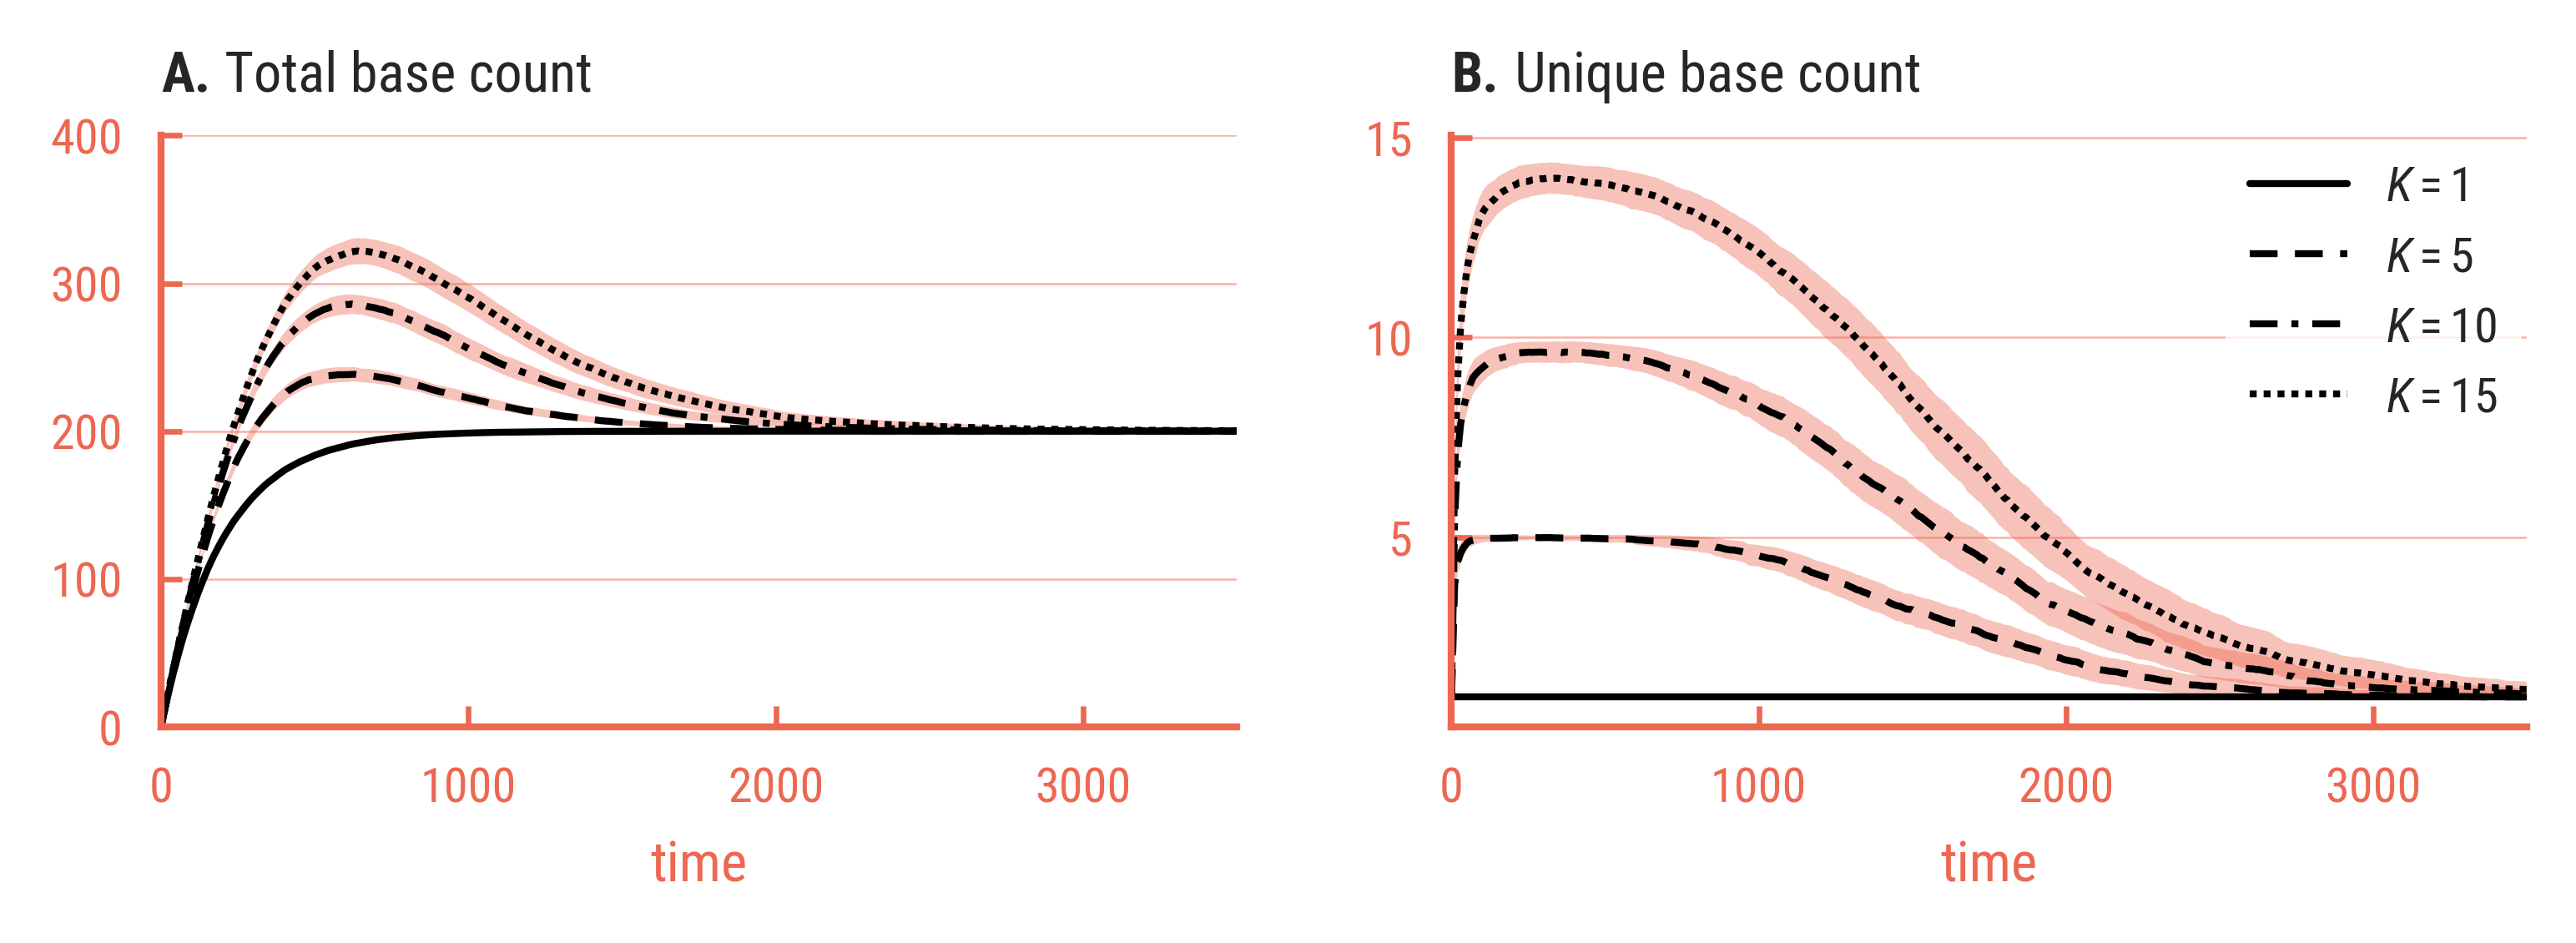

In [6]:
# Plot
figure(figsize=cm2inch(12,3))
xs = data.index
dashes = {30: (1,1), 20: (4,2,1,2), 10: (4,2.5), 1:()}

def plot_results(name):
    for B in [1, 10, 20, 30]:
        mean = data[f'B={B}'][name]['mean']
        std = data[f'B={B}'][name]['std']
        K = int(ceil(B/2))
        plot(xs, mean, 'k', dashes=dashes[B], label=f'$K = {K}$')
        fill_between(xs, mean-.5*std, mean+.5*std, 
                         alpha=.4, facecolor=get_color('orange'))
ax1 = subplot(121)
plot_results('num_bases')
title('Total base count')
xlabel('time')
ylim(0,400)

ax2 = subplot(122)
plot_results('num_unique_bases')
title('Unique base count')
xlabel('time')
legend()

# Format axes
restyle_title(ax1, ax2)
for ax in [ax1, ax2]:
    ax.locator_params(nbins=5, axis='y')
    ax.locator_params(nbins=5, axis='x')
    ax.yaxis.grid()
    ax.set_xlim(0, 3500)
sns.despine()

# Remove all margins, so the plots have exactly the right dimensions
subplots_adjust(left=0, bottom=0, right=1, top=1)
savefig('HUR01-results.pdf', bbox_inches='tight')
copyfig('HUR01-results.pdf')